In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster, linkage

In [4]:
# Load CSV files\
df_data = pd.read_csv('pandas/df_data_abund.csv', low_memory=False)
df_filtered = pd.read_csv('pandas/df_filtered_abund.csv')

agg_df = pd.read_csv('pandas/agg_df_abund_cluster.csv')
fish_df = pd.read_csv('pandas/fish_df_abund_cluster.csv')


Cluster sizes:
cluster
20    893
18    589
17    333
24    168
26    132
27    128
25     71
9      15
12     13
22      9
19      7
6       7
7       6
11      5
14      4
10      4
23      4
4       4
16      3
8       3
21      3
1       2
5       2
13      2
28      1
15      1
2       1
3       1
29      1
dtype: int64


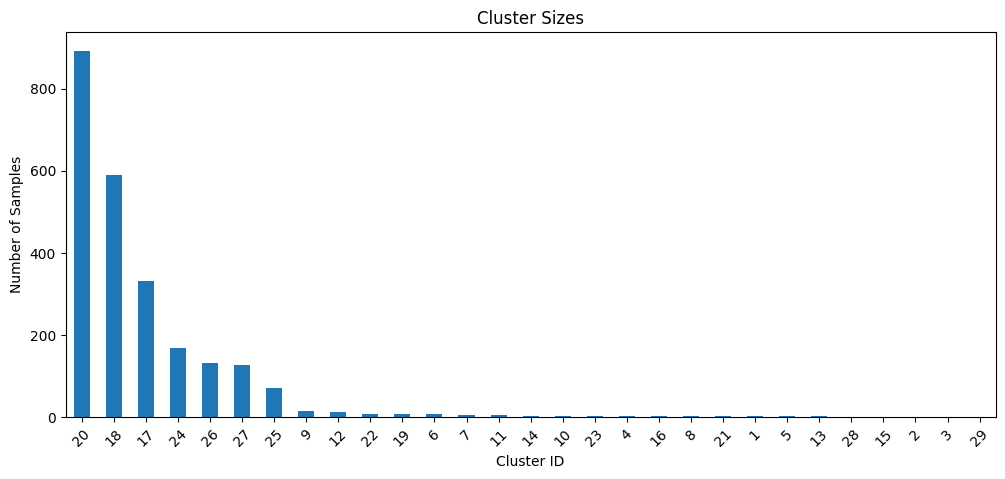

In [5]:
# Summary of clusters
cluster_summary = agg_df.groupby('cluster').size().sort_values(ascending=False)
print(f"\nCluster sizes:")
print(cluster_summary.head(30))

# Visualize cluster size distribution
plt.figure(figsize=(12, 5))
cluster_summary.plot(kind='bar')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Samples')
plt.title('Cluster Sizes')
plt.xticks(rotation=45);
#print(agg_df.groupby('cluster').size())

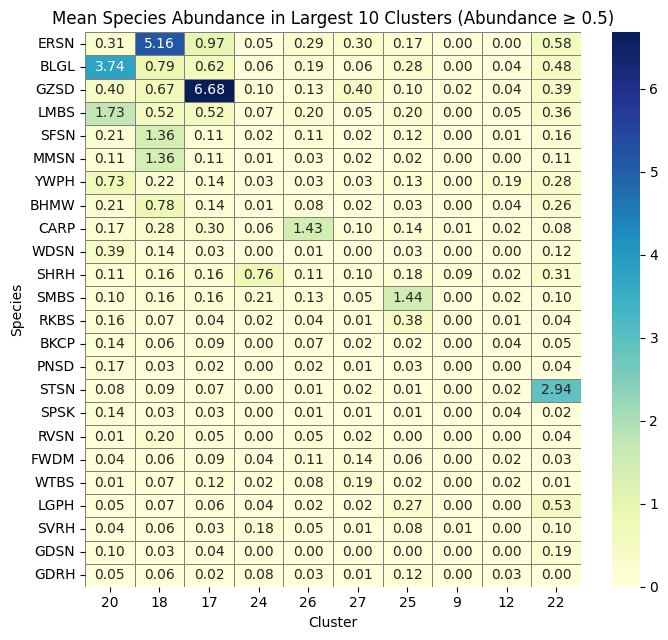

In [6]:
# Order species by overall frequency of occurrence (sum across columns)
species_cols = [c for c in fish_df.columns if c != 'cluster']
species_order = fish_df[species_cols].sum(axis=0).sort_values(ascending=False).index.tolist()

# Compute mean abundance per cluster (not percent presence)
abundance_comp = fish_df.groupby('cluster')[species_order].mean()

# Find the largest 10 clusters by sample size
largest_clusters = fish_df['cluster'].value_counts().nlargest(10).index

# Filter to largest clusters only
abundance_comp_largest = abundance_comp.loc[largest_clusters]

# Only keep species where the maximum mean abundance across the 
# largest clusters is >= 0.1
filt = abundance_comp_largest.max() >= 0.1
abundance_comp_largest = abundance_comp_largest.loc[:, filt]

# Plot heatmap (species as rows, clusters as columns) with higher contrast colormap
plt.figure(figsize=(8, 0.3 * abundance_comp_largest.shape[1]))
sns.heatmap(
    abundance_comp_largest.T,
    cmap='YlGnBu',  # higher contrast than 'Blues'
    annot=True,
    fmt=".2f",
    cbar=True,
    linewidths=0.5,
    linecolor='gray'
)
plt.xlabel("Cluster")
plt.ylabel("Species")
plt.title("Mean Species Abundance in Largest 10 Clusters (Abundance ≥ 0.5)")
plt.show()

In [7]:
# Specify cluster to analyze
cluster_num = 1

# Filter data for this cluster
cluster_data = agg_df[agg_df['cluster'] == cluster_num]
cluster_fish_data = df_filtered[df_filtered['barcode'].isin(cluster_data['barcode'])]

# Environmental variables summary (median)
env_vars = ['median_temp', 'median_depth', 'median_current', 'median_esveg92', 'median_cond']
env_summary = cluster_data[env_vars].median()

# Categorical variables summary (mode)
cat_vars = ['mode_substrt']
cat_summary = cluster_data[cat_vars].mode().iloc[0]

# Binary variables summary (proportion present)
binary_vars = ['snag_present', 'riprap_present', 'inout_present', 'flooded_present']
binary_summary = cluster_data[binary_vars].mean()

# Fish species counts
fish_in_cluster = fish_df[agg_df['cluster'] == cluster_num].drop(columns=['cluster'])
species_counts = fish_in_cluster.sum().sort_values(ascending=False)
species_counts = species_counts[species_counts > 0]

cluster_barcodes = agg_df[agg_df['cluster'] == cluster_num]['barcode']

# Total individuals caught
fish_abundance = df_filtered[df_filtered['barcode'].isin(cluster_barcodes)].groupby('fishcode').size()
fish_length = cluster_fish_data.groupby('fishcode')['length'].mean()
#fish_weight = cluster_fish_data.groupby('fishcode')['weight'].mean()

# Number of samples where present
fish_occurrence = fish_in_cluster.sum()

# Combine
species_summary = pd.DataFrame({
    'total_caught': fish_abundance,
    'samples': fish_occurrence,
    'mean_length': round(fish_length,1),
#    'mean_weight': fish_weight
}).fillna(0).astype({'total_caught': int, 'samples': int})
species_summary = species_summary[species_summary['samples'] > 0].sort_values('samples', ascending=False)

# Print summary
print(f"=== CLUSTER {cluster_num} SUMMARY ===")
print(f"\nTotal samples (identified by barcode): {len(cluster_data)}")
print("\n--- Environmental Variables (Median) ---")
print(env_summary)
print("\n--- Categorical Variables (Mode) ---")
print(cat_summary)
print("\n--- Binary Variables (Proportion Present) ---")
print(binary_summary)
print(f"\n--- Fish Species (Count of {len(cluster_data)} samples) ---")
print(species_summary)

=== CLUSTER 1 SUMMARY ===

Total samples (identified by barcode): 2

--- Environmental Variables (Median) ---
median_temp         9.55
median_depth        1.75
median_current      0.66
median_esveg92      0.00
median_cond       449.00
dtype: float64

--- Categorical Variables (Mode) ---
mode_substrt    2.0
Name: 0, dtype: float64

--- Binary Variables (Proportion Present) ---
snag_present       0.0
riprap_present     0.0
inout_present      0.0
flooded_present    0.0
dtype: float64

--- Fish Species (Count of 2 samples) ---
Empty DataFrame
Columns: [total_caught, samples, mean_length]
Index: []


In [8]:
df_explore = agg_df 
fish_explore = fish_df

In [9]:
# Summarize all clusters at once
for cluster_num in sorted(df_explore['cluster'].unique()):
    cluster_data = df_explore[df_explore['cluster'] == cluster_num]
    cluster_fish_data = df_data[df_data['barcode'].isin(cluster_data['barcode'])]
    
    # Environmental variables summary (median)
    env_vars = ['median_temp', 'median_depth', 'median_current', 'median_esveg92', 'median_cond']
    env_summary = cluster_data[env_vars].median()

    # Categorical variables summary (mode)
    cat_vars = ['mode_substrt']
    cat_summary = cluster_data[cat_vars].mode().iloc[0]

    # Binary variables summary (proportion present)
    binary_vars = ['snag_present', 'riprap_present', 'inout_present', 'flooded_present']
    binary_summary = cluster_data[binary_vars].mean()

    # Fish species counts
    fish_in_cluster = fish_explore[df_explore['cluster'] == cluster_num].drop(columns=['cluster'])
    species_counts = fish_in_cluster.sum().sort_values(ascending=False)
    species_counts = species_counts[species_counts > 0]

    cluster_barcodes = df_explore[df_explore['cluster'] == cluster_num]['barcode']

    # Total individuals caught
    fish_abundance = df_filtered[df_filtered['barcode'].isin(cluster_barcodes)].groupby('fishcode').size()
    fish_length = cluster_fish_data.groupby('fishcode')['length'].mean()
    #fish_weight = cluster_fish_data.groupby('fishcode')['weight'].mean()

    # Number of samples where present
    fish_occurrence = fish_in_cluster.sum()

    # Combine
    species_summary = pd.DataFrame({
        'total_caught': fish_abundance,
        'samples': fish_occurrence,
        'mean_length': round(fish_length,1),
#    'mean_weight': fish_weight
    }).fillna(0).astype({'total_caught': int, 'samples': int})
    species_summary = species_summary[species_summary['samples'] > 0].sort_values('samples', ascending=False)


    # Print summary
    print(f"=== CLUSTER {cluster_num} SUMMARY ===")
    print(f"\nTotal samples (identified by barcode): {len(cluster_data)}")
    print("\n--- Environmental Variables (Median) ---")
    print(env_summary)
    print("\n--- Categorical Variables (Mode) ---")
    print(cat_summary)
    print("\n--- Binary Variables (Proportion Present) ---")
    print(binary_summary)
    print(f"\n--- Fish Species (Count of {len(cluster_data)} samples) ---")
    print(species_summary)

=== CLUSTER 1 SUMMARY ===

Total samples (identified by barcode): 2

--- Environmental Variables (Median) ---
median_temp         9.55
median_depth        1.75
median_current      0.66
median_esveg92      0.00
median_cond       449.00
dtype: float64

--- Categorical Variables (Mode) ---
mode_substrt    2.0
Name: 0, dtype: float64

--- Binary Variables (Proportion Present) ---
snag_present       0.0
riprap_present     0.0
inout_present      0.0
flooded_present    0.0
dtype: float64

--- Fish Species (Count of 2 samples) ---
Empty DataFrame
Columns: [total_caught, samples, mean_length]
Index: []
=== CLUSTER 2 SUMMARY ===

Total samples (identified by barcode): 1

--- Environmental Variables (Median) ---
median_temp         7.80
median_depth        1.03
median_current      0.02
median_esveg92      2.00
median_cond       511.00
dtype: float64

--- Categorical Variables (Mode) ---
mode_substrt    1.0
Name: 0, dtype: float64

--- Binary Variables (Proportion Present) ---
snag_present       1

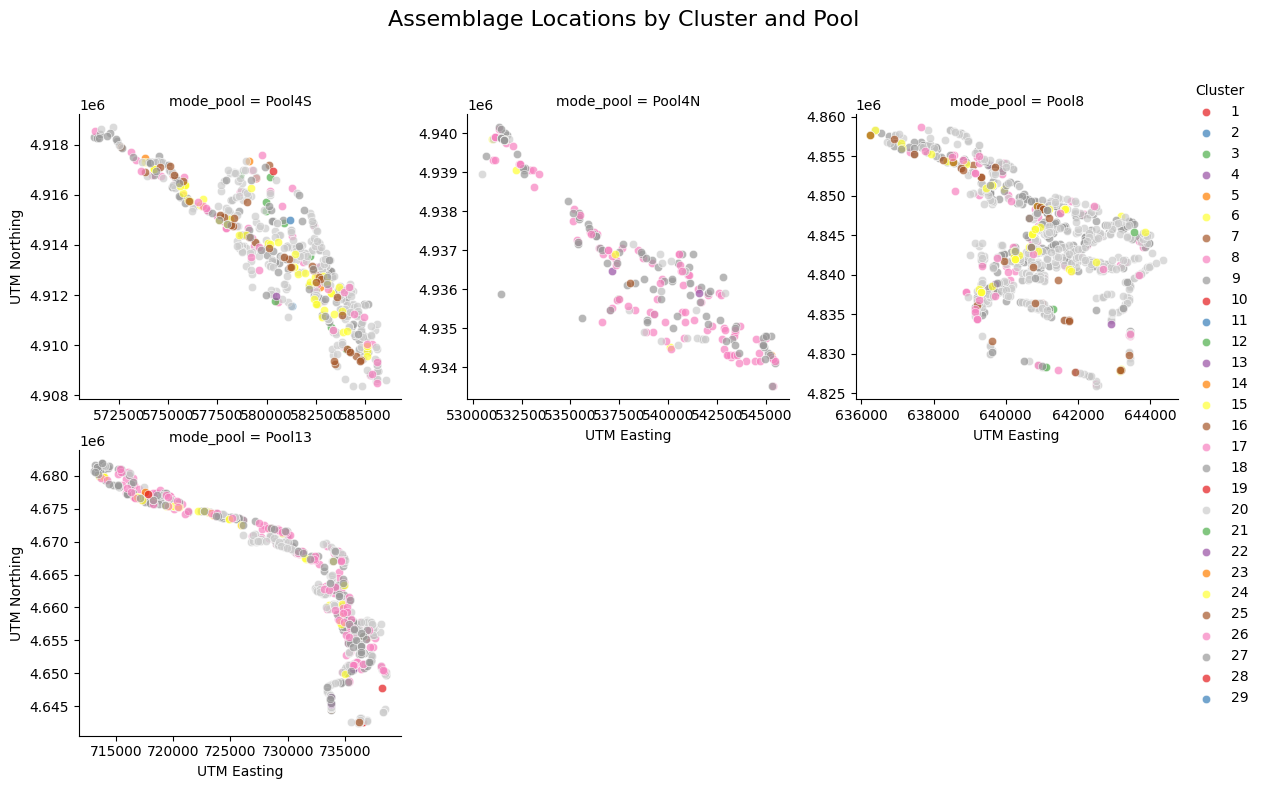

In [10]:
# Find the cluster with the largest count
cluster_sizes = df_explore['cluster'].value_counts()
largest_cluster = df_explore['cluster'].value_counts().idxmax()
unique_clusters = sorted(df_explore['cluster'].unique())
size_map = {c: f"{cluster_sizes[c]} sites" for c in unique_clusters}
palette = sns.color_palette("Set1", n_colors=len(unique_clusters))
light_color = (0.8, 0.8, 0.8)  # RGB for light gray

# Assign palette, but set largest cluster to light gray
color_map = {c: col for c, col in zip(unique_clusters, palette)}
color_map[largest_cluster] = light_color

g = sns.FacetGrid(
    df_explore,
    col="mode_pool",
    hue="cluster",
    palette=color_map,
    col_wrap=3,
    height=4,
    sharex=False,
    sharey=False
)
g.map_dataframe(sns.scatterplot, x="utm_e", y="utm_n", alpha=0.7)
g.add_legend(title="Cluster")
g.set_axis_labels("UTM Easting", "UTM Northing")
g.figure.subplots_adjust(top=0.85)
g.figure.suptitle("Assemblage Locations by Cluster and Pool", fontsize=16)
plt.show()

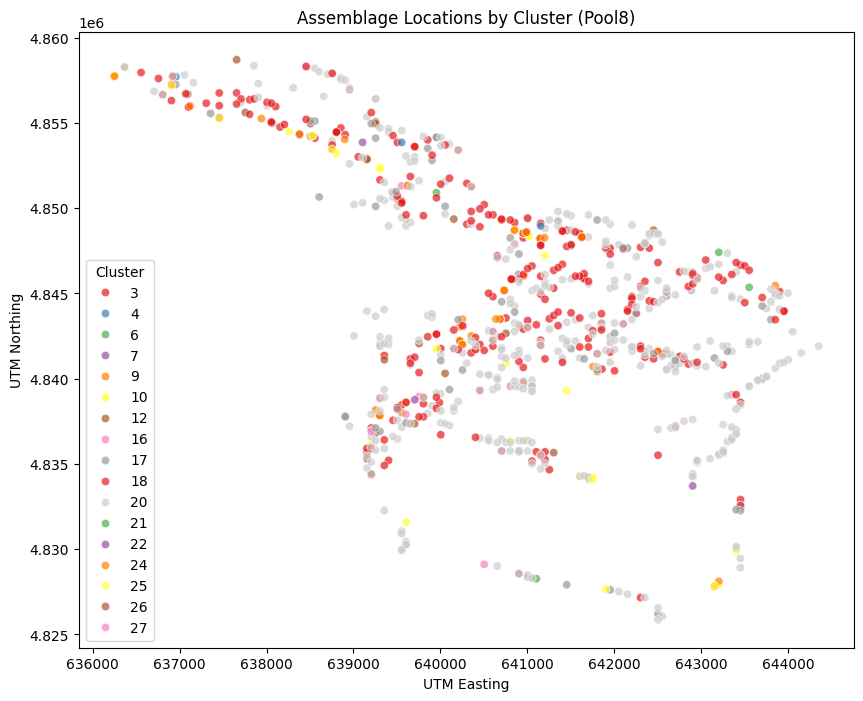

In [11]:
# Filter by specified pool
pool_filter = 'Pool8'  # Change this to desired pool value
available_pools = sorted(df_explore['mode_pool'].unique().tolist())

if pool_filter not in available_pools:
    print(f"No rows for mode_pool == {pool_filter}. Available pools: {available_pools}")
else:
    df_pool = df_explore[df_explore['mode_pool'] == pool_filter].copy()
    
    # Get cluster info for this pool
    cluster_sizes_pool = df_pool['cluster'].value_counts()
    unique_clusters_pool = sorted(df_pool['cluster'].unique())
    
    # Create color palette
    palette = sns.color_palette("Set1", n_colors=len(unique_clusters_pool))
    light_color = (0.8, 0.8, 0.8)
    color_map = {c: col for c, col in zip(unique_clusters_pool, palette)}
    
    # Set largest cluster to light gray
    if not cluster_sizes_pool.empty:
        largest_cluster_pool = cluster_sizes_pool.idxmax()
        color_map[largest_cluster_pool] = light_color
    
    # Plot
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        data=df_pool,
        x="utm_e",
        y="utm_n",
        hue="cluster",
        palette=color_map,
        alpha=0.7
    )
    plt.xlabel("UTM Easting")
    plt.ylabel("UTM Northing")
    plt.title(f"Assemblage Locations by Cluster ({pool_filter})")
    plt.legend(title="Cluster")
    plt.show()

/Users/minidude/opt/miniconda3/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1718: RuntimeWarning: divide by zero encountered in scalar divide
/Users/minidude/opt/miniconda3/lib/python3.12/site-packages/plotnine/stats/stat_smooth.py:215: PlotnineWarning: Smoothing requires 2 or more points. Got 1. Not enough points for smoothing. If this message a surprise, make sure the column mapped to the x aesthetic has the right dtype.
/Users/minidude/opt/miniconda3/lib/python3.12/site-packages/plotnine/stats/stat_smooth.py:215: PlotnineWarning: Smoothing requires 2 or more points. Got 1. Not enough points for smoothing. If this message a surprise, make sure the column mapped to the x aesthetic has the right dtype.
/Users/minidude/opt/miniconda3/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1718: RuntimeWarning: divide by zero encountered in scalar divide
/Users/minidude/opt/miniconda3/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1

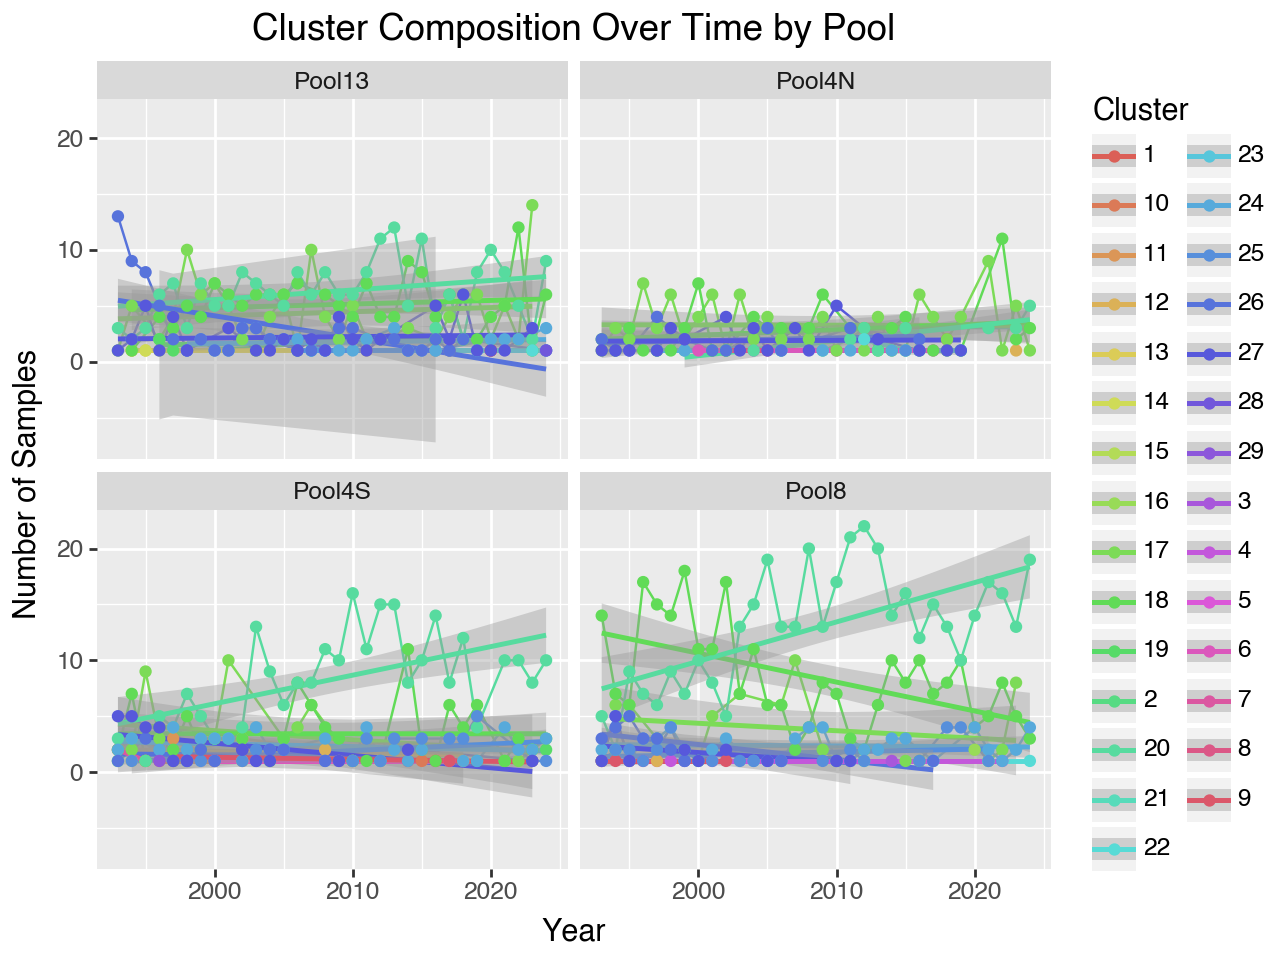

In [12]:
from plotnine import *

# Count samples per year per cluster per pool
cluster_time_pool = df_explore.groupby(['year', 'cluster', 'mode_pool']).size().reset_index(name='count')
cluster_time_pool['cluster'] = cluster_time_pool['cluster'].astype(str)

# Create the plot with faceting by pool
(ggplot(cluster_time_pool, aes(x='year', y='count', color='cluster')) +
 geom_line() +
 geom_smooth(method = 'lm') +
 geom_point() +
 facet_wrap('~mode_pool') +
 labs(x='Year', y='Number of Samples', color='Cluster', 
    title='Cluster Composition Over Time by Pool') 
    #+
 #scale_y_log10()
 )

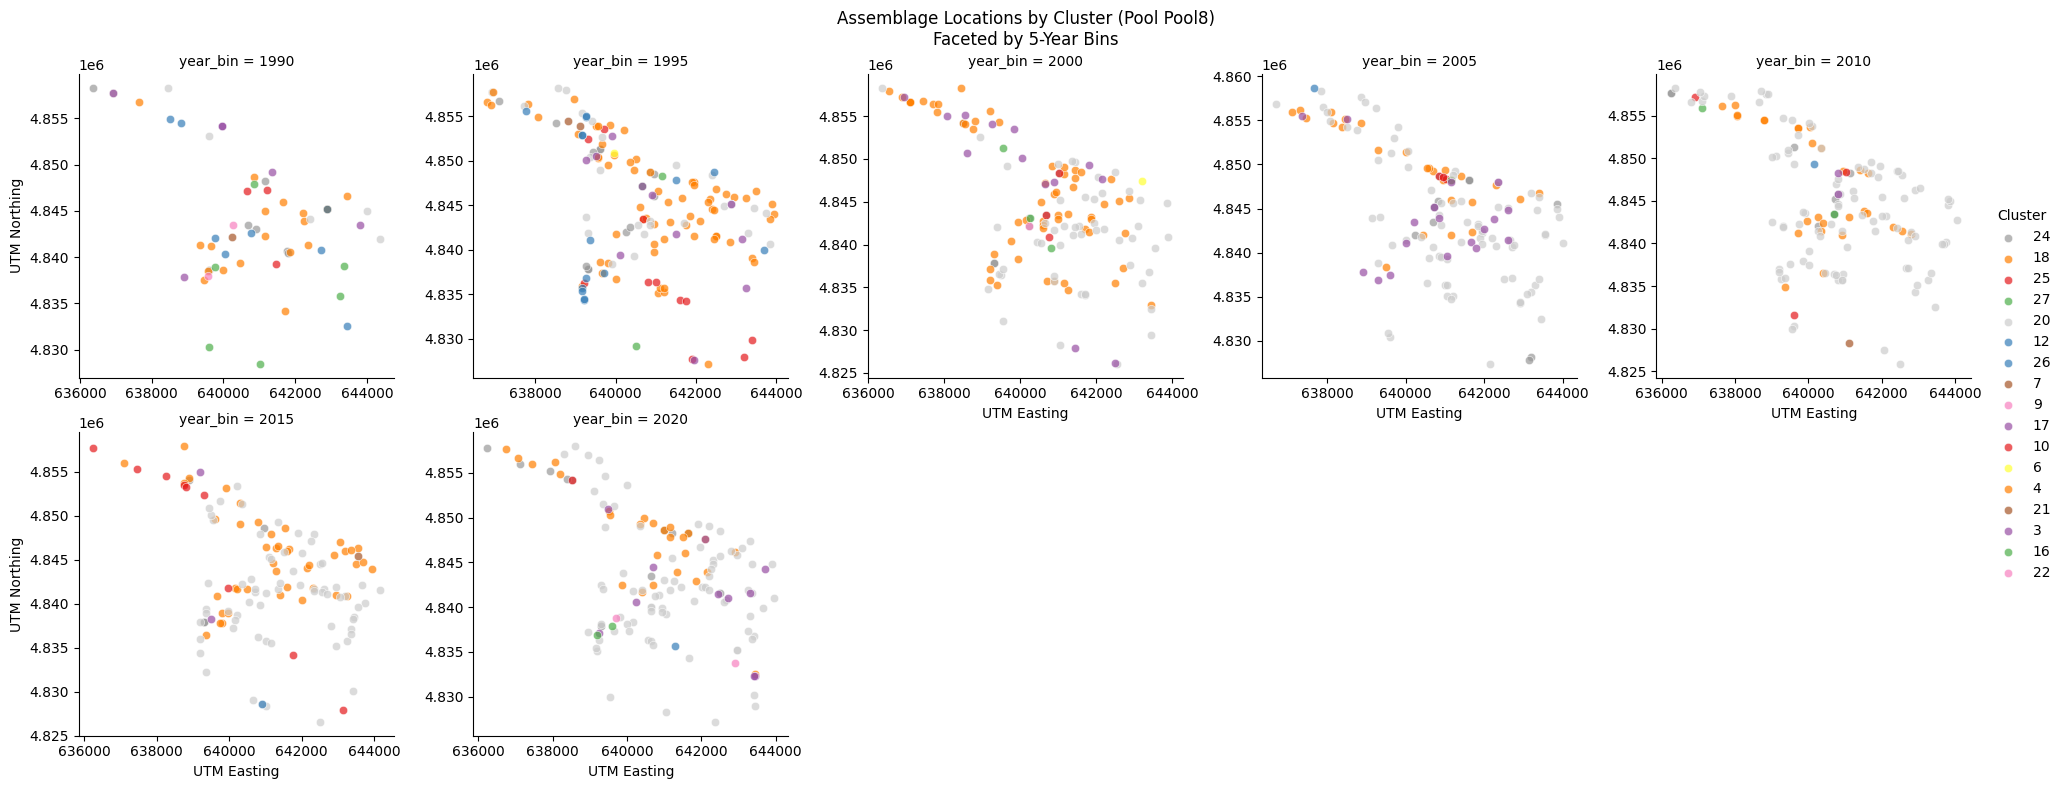

In [13]:
# Create a new column for year bins
df_pool['year_bin'] = (df_pool['year'] // 5) * 5

# Ensure cluster column is string type for consistency
df_pool['cluster'] = df_pool['cluster'].astype(str)

# Create color map specifically for clusters present in df_pool
unique_clusters_pool = sorted(df_pool['cluster'].unique())
palette = sns.color_palette("Set1", n_colors=len(unique_clusters_pool))

# Create color map only for clusters in this pool
color_map_pool = {c: col for c, col in zip(unique_clusters_pool, palette)}

# Optional: Set largest cluster to light gray
cluster_sizes_pool = df_pool['cluster'].value_counts()
if not cluster_sizes_pool.empty:
    largest_cluster_pool = cluster_sizes_pool.idxmax()
    color_map_pool[largest_cluster_pool] = (0.8, 0.8, 0.8)  # light gray

# Create the FacetGrid
g = sns.FacetGrid(
    df_pool,
    col="year_bin",
    col_wrap=5,
    height=4,
    sharex=False,
    sharey=False,
    hue="cluster",
    palette=color_map_pool  # Use pool-specific color map
)
g.map_dataframe(
    sns.scatterplot,
    x="utm_e",
    y="utm_n",
    alpha=0.7
)
g.add_legend(title="Cluster")
g.set_axis_labels("UTM Easting", "UTM Northing")
g.figure.subplots_adjust(top=0.9)
g.figure.suptitle(f"Assemblage Locations by Cluster (Pool {pool_filter})\nFaceted by 5-Year Bins")
plt.show()